## Get Started with Projected Gradient Descent Attack

__Description__:

This notebook quickly demonstrates the use of the Projected Gradient Descent attack in code as part of Test & Evaluation of small benchmark datasets (MNIST and CIFAR-10). 
Key features:
- Attacks are demonstrated using parallel and non-parallel mode.
- Extracting attack metadata to determine the best performing attacks.
- Calculating clean and robust accuracy
- Calculating perturbation

__Intended Audience__: All T&E users

## Contents
1. Imports
2. Load CIFAR-10 model and data for classification
3. Load HuggingFace dataset for prediction
4. Load TorchVision dataset for prediction
5. Load TorchVision model for prediction
6. Define and run PGD attack
7. Extract Clean and Robust accuracy
8. JATIC Supported PGD attack
9. Extract Clean and Robust accuracy
10. JATIC Supported PGD Attack with HuggingFace dataset
11. Other Evasion Attacks
    - Carlini Attack
    - HopSkipJump (untargeted)
    - HopSkipJump (targeted)

### 1. Imports

In [1]:
from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

from art.utils import load_dataset as load_dataset_art

from art.attacks.evasion import ProjectedGradientDescentPyTorch
from heart_library.metrics import AccuracyPerturbationMetric

from art.attacks.evasion.hop_skip_jump import HopSkipJump

%matplotlib inline


### 2. Load CIFAR-10 model and data for classification

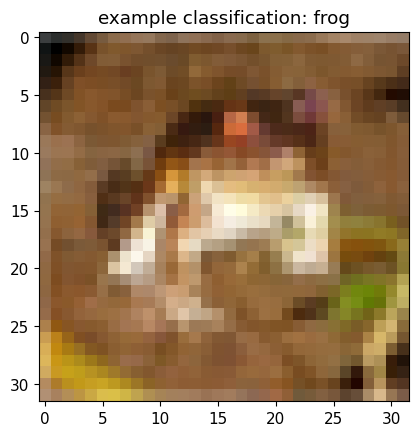

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset_art('cifar10')
i = 100
x_train = x_train[:100, :].transpose(0, 3, 1, 2).astype('float32')*255
x_test = x_test[:100, :].transpose(0, 3, 1, 2).astype('float32')*255
y_train = y_train[:100, :].astype('float32')
y_test = y_test[:100, :].astype('float32')

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path = '../'

class Model(torch.nn.Module):
        """
        Create model for pytorch.
        Here the model does not use maxpooling. Needed for certification tests.
        """

        def __init__(self):
            super(Model, self).__init__()

            self.conv = torch.nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
            )

            self.fullyconnected = torch.nn.Linear(in_features=1600, out_features=10)

            self.relu = torch.nn.ReLU()

            w_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            w_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )

            self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
            self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
            self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
            self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

        def forward(self, x):
            """
            Forward function to evaluate the model
            :param x: Input to the model
            :return: Prediction of the model
            """
            x = self.conv(x)
            x = self.relu(x)
            x = x.reshape(-1, 1600)
            x = self.fullyconnected(x)
            x = torch.nn.functional.softmax(x, dim=1)
            return x

# Define the network
model = Model()

# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Get classifier
jptc = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10, clip_values=(0, 255),
    preprocessing=(0.0, 255)
    
)
plt.imshow(x_train[0].transpose(1,2,0).astype(np.uint8))

pred_batch = jptc(x_train[[0]])
_ = plt.title(f'example classification: {labels[np.argmax(np.stack(pred_batch))]}')

### 3. Load HuggingFace dataset for prediction

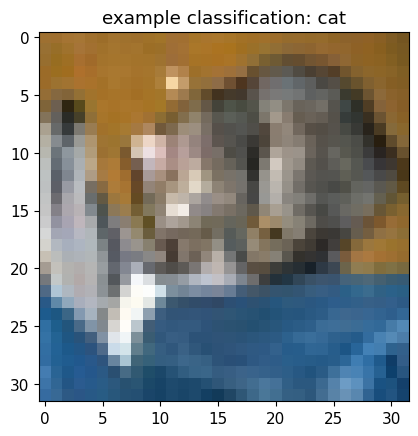

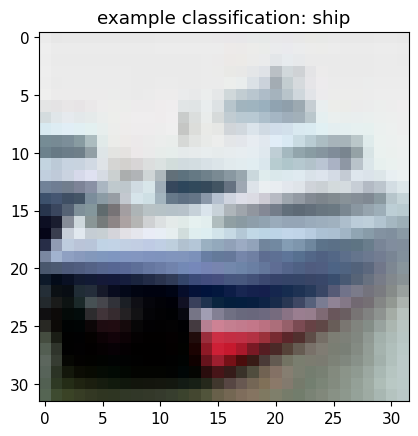

In [5]:
from datasets import load_dataset

data = load_dataset("cifar10", split="test[0:10]")

import matplotlib.pyplot as plt

pred_batch = jptc(data)
predictions = np.argmax(np.stack(pred_batch), axis=1)
for i, pred in enumerate(predictions[:2]):
    plt.imshow(np.asarray(data.__getitem__(i)['img']))
    plt.title(f'example classification: {labels[pred]}')
    plt.show()

### 4. Load TorchVision dataset for prediction

Files already downloaded and verified


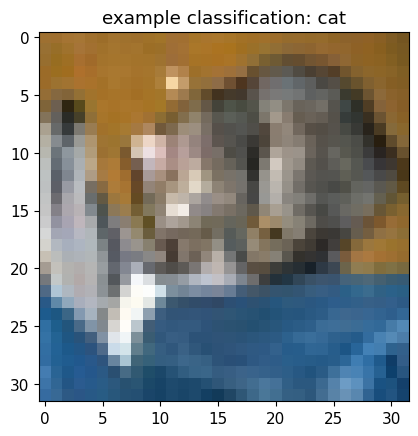

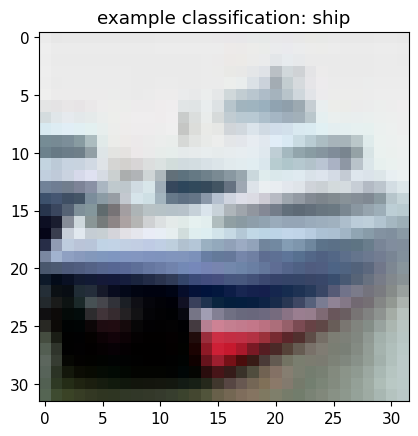

In [6]:
import torchvision

data = torchvision.datasets.CIFAR10("../data", train=False, download=True)
data = torch.utils.data.Subset(data, list(range(10)))

pred_batch = jptc(data)
predictions = np.argmax(np.stack(pred_batch), axis=1)
for i, pred in enumerate(predictions[:2]):
    plt.imshow(np.asarray(data.__getitem__(i)[0]))
    plt.title(f'example classification: {labels[pred]}')
    plt.show()

### 5. Load TorchVision model for prediction

In [7]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

data = torchvision.datasets.CIFAR10("../data", train=False, transform=preprocess, download=True)
data = torch.utils.data.Subset(data, list(range(10)))

Files already downloaded and verified


In [8]:
from torchvision.models import resnet18, ResNet18_Weights
import requests

response = requests.get("https://git.io/JJkYN")
imagenet_labels = response.text.split("\n")

resnet_model = resnet18(ResNet18_Weights)

resnet_jptc = JaticPyTorchClassifier(
    model=resnet_model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 224, 224), nb_classes=1000, clip_values=(0, 1),
    preprocessing=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
)

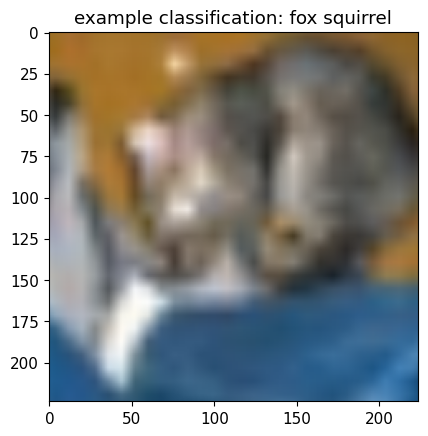

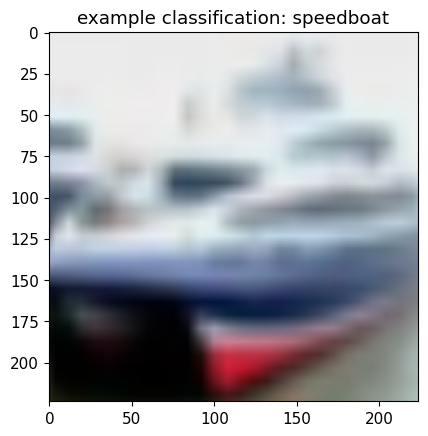

In [9]:
pred_batch = resnet_jptc(data)
predictions = np.argmax(np.stack(pred_batch), axis=1)
for i, pred in enumerate(predictions[:2]):
    plt.imshow(np.asarray(data.__getitem__(i)[0]).transpose(1,2,0))
    plt.title(f'example classification: {imagenet_labels[pred]}')
    plt.show()

#### Same but for Hugging Face

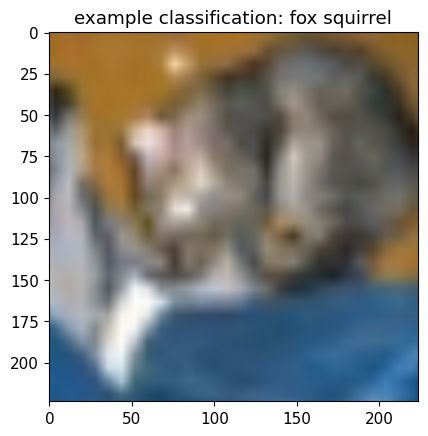

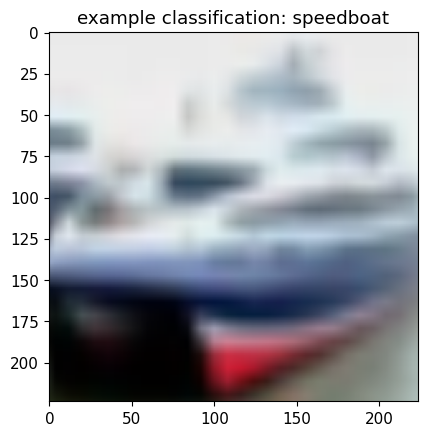

In [10]:
from datasets import load_dataset

data = load_dataset("cifar10", split="test[0:10]")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

data = data.map(lambda x: {"img": preprocess(x["img"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))

jptc = JaticPyTorchClassifier(
    model='microsoft/resnet-18', loss=loss_fn, optimizer=optimizer, input_shape=(3, 224, 224), nb_classes=1000, clip_values=(0, 1),
    preprocessing=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), provider="huggingface"
)

pred_batch = jptc(data)
predictions = np.argmax(np.stack(pred_batch), axis=1)
for i, pred in enumerate(predictions[:2]):
    plt.imshow(to_image(data.__getitem__(i)['img']))
    plt.title(f'example classification: {imagenet_labels[pred]}')
    plt.show()

### 6. Define and run PGD attack

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

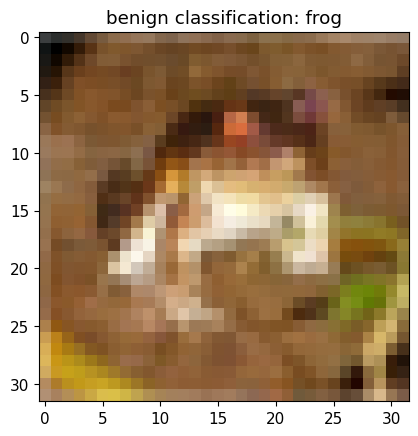

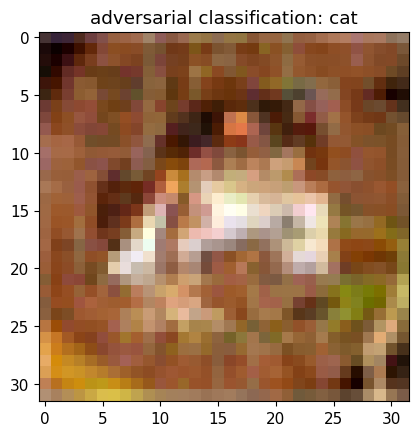

In [11]:
jptc = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10, clip_values=(0, 255),
    preprocessing=(0.0, 255)
)

attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=1000, eps=11, eps_step=0.1, targeted=False)

x_adv = attack.generate(x=x_train[[0]], y=y_train[[0]])


pred_batch = jptc(x_train[[0]])
plt.imshow(x_train[0].transpose(1,2,0).astype(np.uint8))
_ = plt.title(f'benign classification: {labels[np.argmax(np.stack(pred_batch))]}')
plt.show()

pred_batch = jptc(x_adv[[0]])
plt.imshow(x_adv[0].transpose(1,2,0).astype(np.uint8))
_ = plt.title(f'adversarial classification: {labels[np.argmax(np.stack(pred_batch))]}')
plt.show()

### 8. JATIC Suported PGD Attack

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

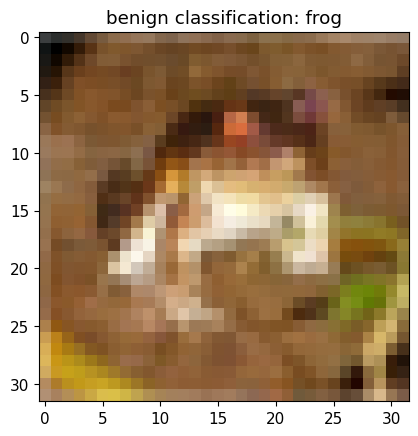

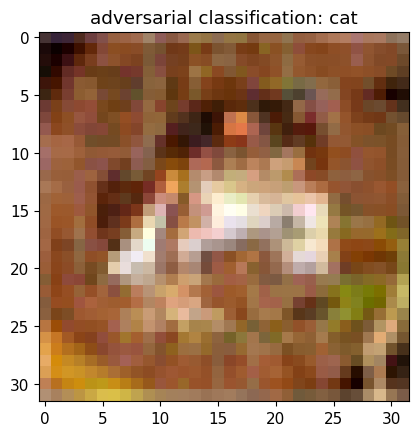

In [12]:
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from heart_library.attacks.attack import JaticAttack

pgd_attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=1000, eps=11, eps_step=0.1, targeted=False)
attack = JaticAttack(pgd_attack, norm=2)

x_adv, _, metadata = attack(data=x_train[[0]])

pred_batch = jptc(x_train[[0]])
plt.imshow(x_train[0].transpose(1,2,0).astype(np.uint8))
_ = plt.title(f'benign classification: {labels[np.argmax(np.stack(pred_batch))]}')
plt.show()

pred_batch = jptc(np.stack(x_adv)[[0]])
plt.imshow(x_adv[0].transpose(1,2,0).astype(np.uint8))
_ = plt.title(f'adversarial classification: {labels[np.argmax(np.stack(pred_batch))]}')
plt.show()

In [13]:
groundtruth_target_batch = [np.argmax(y_train[[0]], axis=1)]
benign_preds_batch = jptc(x_train[[0]])
adversarial_preds_batch = jptc(x_adv)

metric = AccuracyPerturbationMetric(benign_preds_batch, metadata)
metric.update(adversarial_preds_batch, groundtruth_target_batch)
print(metric.compute())

{'clean_accuracy': 1.0, 'robust_accuracy': 0.0, 'mean_delta': 581.4564}


In [14]:
from typing import Tuple, Dict, Any
from maite.protocols.image_classification import Dataset as ic_dataset
class TargetedImageDataset:
    
    metadata: Dict = {"id": "example"}
    
    def __init__(self, images):
        self.images = images
    def __len__(self)->int:
        return len(self.images)
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images[ind]
        return image, 2, {}
    
data = TargetedImageDataset(x_train)
assert isinstance(data, ic_dataset)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

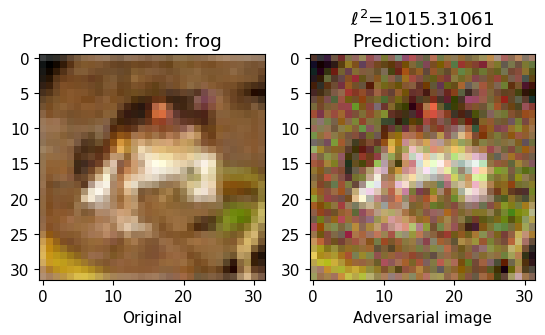

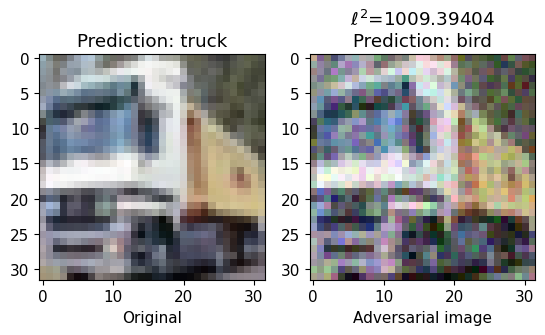

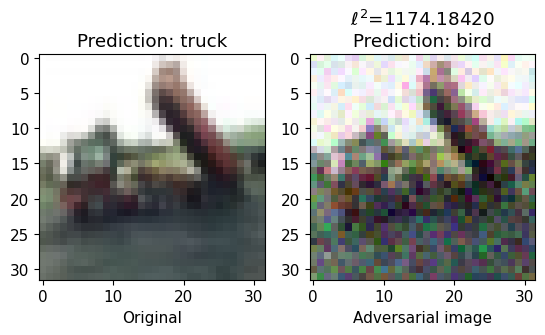

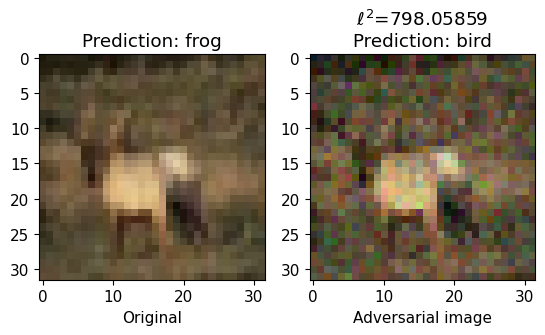

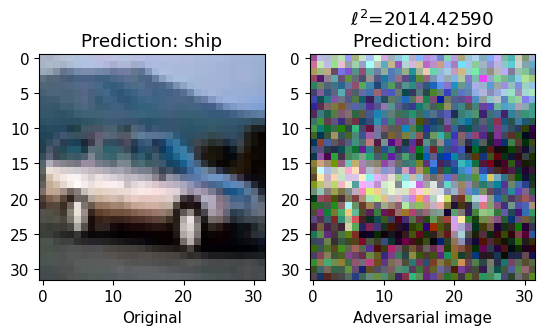

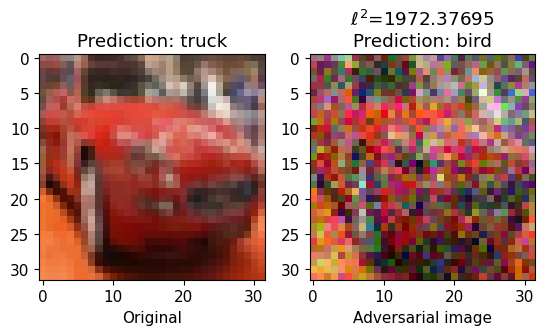

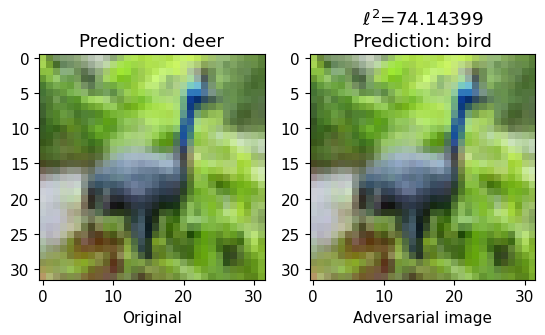

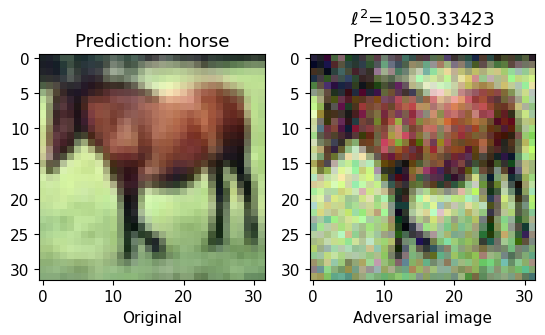

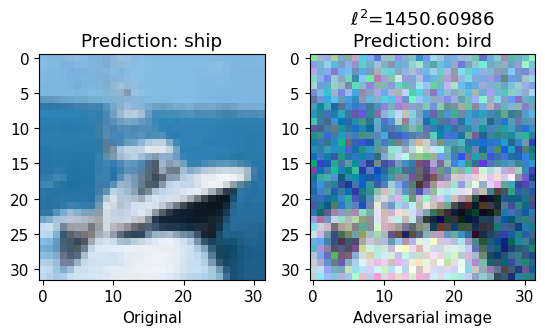

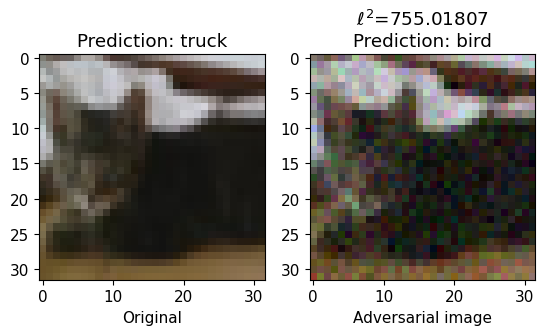

In [15]:
hsj_attack = HopSkipJump(classifier=jptc, targeted=True, verbose=True, max_iter=50, max_eval=10, init_eval=10)
attack = JaticAttack(hsj_attack, norm=2)

x_adv, _, metadata = attack(data=data)

for i in range(10):
    f, ax = plt.subplots(1,2)
    norm_orig_img = data.__getitem__(i)[0].astype(np.float32)
    perturbation = np.linalg.norm(norm_orig_img - x_adv[i])

    pred_batch = jptc(norm_orig_img)
    ax[0].set_title(f'Prediction: {labels[np.argmax(np.stack(pred_batch))]}')
    ax[0].imshow(norm_orig_img.transpose(1,2,0).astype(np.uint8))
    ax[0].set_xlabel('Original')

    pred_batch = jptc(x_adv[i])
    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {labels[np.argmax(np.stack(pred_batch))]}')
    ax[1].imshow(x_adv[i].transpose(1,2,0).astype(np.uint8))
    ax[1].set_xlabel('Adversarial image')
    plt.show()

### 10. JATIC Supported PGD Attack with HuggingFace dataset
Example on single channel dataset (MNIST)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

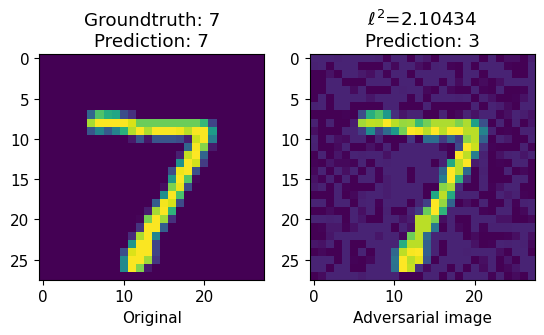

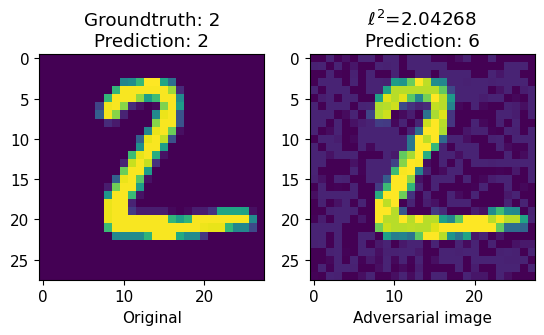

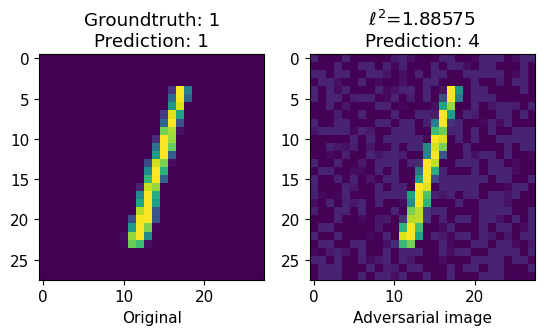

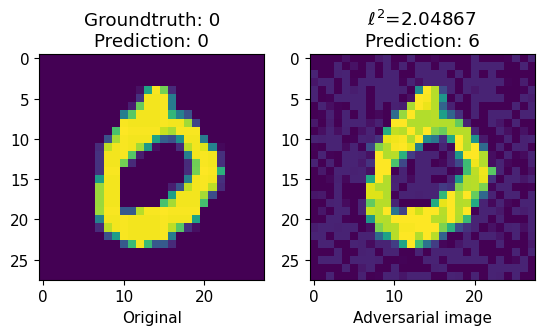

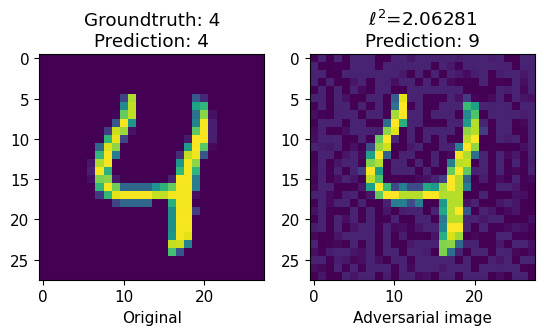

In [16]:
from datasets import load_dataset

data = load_dataset("mnist", split="test[0:10]")
labels = list(range(10))

preprocess = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))

jptc = JaticPyTorchClassifier(
    model='fxmarty/resnet-tiny-mnist', loss=loss_fn, optimizer=optimizer, input_shape=(1, 28, 28), nb_classes=10, clip_values=(0, 1),
    provider="huggingface", preprocessing=([0.45], [0.22]),
)

evasion_attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=500, eps=0.1, eps_step=0.01)
# evasion_attack = HopSkipJump(classifier=jptc, max_iter=100, max_eval=100, init_eval=1, init_size=1, verbose=True)
attack = JaticAttack(evasion_attack)

x_adv, _, metadata = attack(data=data, norm=2)

preds = np.stack(jptc(data))
pred_adv = np.stack(jptc(x_adv))

for i in range(5):
    f, ax = plt.subplots(1,2)
    norm_orig_img = np.asarray(data.__getitem__(i)["image"]).astype(np.float32)
    perturbation = np.linalg.norm(norm_orig_img - x_adv[i])

    ax[0].set_title(f'Groundtruth: {labels[data.__getitem__(i)["label"]]}\nPrediction: {labels[np.argmax(preds[i])]}')
    ax[0].imshow(norm_orig_img.transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {labels[np.argmax(pred_adv[i])]}')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Adversarial image')
    plt.show()

Example on 3-channel CIFAR-10 dataset

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

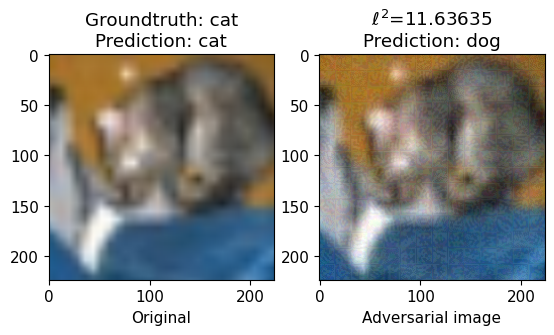

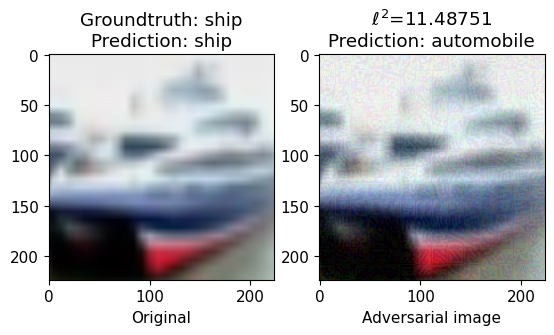

In [17]:
from datasets import load_dataset

data = load_dataset("cifar10", split="test[0:10]")
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

data = data.map(lambda x: {"img": preprocess(x["img"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))

jptc = JaticPyTorchClassifier(
    model='nateraw/vit-base-patch16-224-cifar10', loss=loss_fn, optimizer=optimizer, input_shape=(3, 224, 224), nb_classes=10, clip_values=(0, 1),
    preprocessing=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), provider="huggingface",
)

pgd_attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=10, eps=0.03)
attack = JaticAttack(pgd_attack, norm=2)

x_adv, y, metadata = attack(data=data)

preds = np.stack(jptc(data))
pred_adv = np.stack(jptc(x_adv))

for i in range(2):
    f, ax = plt.subplots(1,2)
    norm_orig_img = np.asarray(data.__getitem__(i)["img"]).astype(np.float32)
    perturbation = np.linalg.norm(norm_orig_img - x_adv[i])

    ax[0].set_title(f'Groundtruth: {labels[data.__getitem__(i)["label"]]}\nPrediction: {labels[np.argmax(preds[i])]}')
    ax[0].imshow(norm_orig_img.transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {labels[np.argmax(pred_adv[i])]}')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Adversarial image')
    plt.show()

In [18]:
groundtruth_target_batch = y
benign_pred_batch = jptc(data)
adv_pred_batch = jptc(x_adv)

metric = AccuracyPerturbationMetric(benign_pred_batch, metadata)
metric.update(adv_pred_batch, groundtruth_target_batch)
print(metric.compute())

{'clean_accuracy': 0.9, 'robust_accuracy': 0.0, 'mean_delta': 11.617389}
